In [68]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/marketing-ab-testing


In [69]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = UserWarning)

df = pd.read_csv("/kaggle/input/marketing-ab-testing/marketing_AB.csv")
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


# Step 1: Understand the Dataset

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


### Data Dictionary

* user id: User ID (unique)
* test group: representing either "ad" or "psa"
* converted: indicating whether the user converted (True) or not (False)
* total ads: number of ads seen
* most ads day: day of the week when most ads were seen
* most ads hour: Hour of day when most ads were seen

In [71]:
df["test group"].value_counts()

test group
ad     564577
psa     23524
Name: count, dtype: int64

In [72]:
df["converted"].value_counts()

converted
False    573258
True      14843
Name: count, dtype: int64

In [73]:
df["total ads"].describe()

count    588101.000000
mean         24.820876
std          43.715181
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000
Name: total ads, dtype: float64

In [74]:
df["most ads day"].describe()

count     588101
unique         7
top       Friday
freq       92608
Name: most ads day, dtype: object

In [75]:
df["most ads hour"].describe()

count    588101.000000
mean         14.469061
std           4.834634
min           0.000000
25%          11.000000
50%          14.000000
75%          18.000000
max          23.000000
Name: most ads hour, dtype: float64

# Step 2: Define the Hypotheses

Null Hypothese (H0): there is no statistical significant difference in the conversation rates between the "ad" group and the "psa" group. P_ad <= P_psa

Alternative Hypothese (H1): there is statistical significant difference in the conversation rates between the "ad" group and the "psa" group. P_ad > P_psa

# Step 3: Hypothesis Testing

Since we are comparing the conversion rates between two independent categorical groups, the ****chi-Squared Test**** is the most suitable statistical test.

In [76]:
ad_group = df[df['test group'] == 'ad']
psa_group = df[df['test group'] == 'psa']

ad_converted_count = ad_group['converted'].sum()
ad_total_users = len(ad_group)
ad_conversion_rate = ad_converted_count / ad_total_users

psa_converted_count = psa_group['converted'].sum()
psa_total_users = len(psa_group)
psa_conversion_rate = psa_converted_count / psa_total_users

print(ad_conversion_rate)
print(psa_conversion_rate)

0.025546559636683747
0.01785410644448223


In [77]:
alpha = 0.05

# Testing H0: P_ad <= P_psa, H1: P_ad > P_psa

from statsmodels.stats.proportion import proportions_ztest

counts = np.array([ad_converted_count, psa_converted_count])
totals = np.array([ad_total_users, psa_total_users])

z_statistic, p_value_one_tailed = proportions_ztest(counts, totals, alternative = 'larger')

if p_value_one_tailed < alpha:
    print("we reject the null hypotheses; this means ads can be considered successful in increasing conversion rate")
else:
    print("we fail to reject the null hypotheses; this means ads can be considered unsuccessful in increasing conversion rate")

we reject the null hypotheses; this means ads can be considered successful in increasing conversion rate


# Step 4: More Observations

In [78]:
conversion_by_day = df.groupby(['test group', 'most ads day'])['converted'].mean().unstack() *100
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
conversion_by_day = conversion_by_day[day_order]

print(conversion_by_day)

most ads day    Monday   Tuesday  Wednesday  Thursday    Friday  Saturday  \
test group                                                                  
ad            3.324120  3.044038   2.535586  2.163714  2.246495  2.130657   
psa           2.255854  1.444788   1.575931  2.023047  1.630292  1.399580   

most ads day    Sunday  
test group              
ad            2.461983  
psa           2.059497  


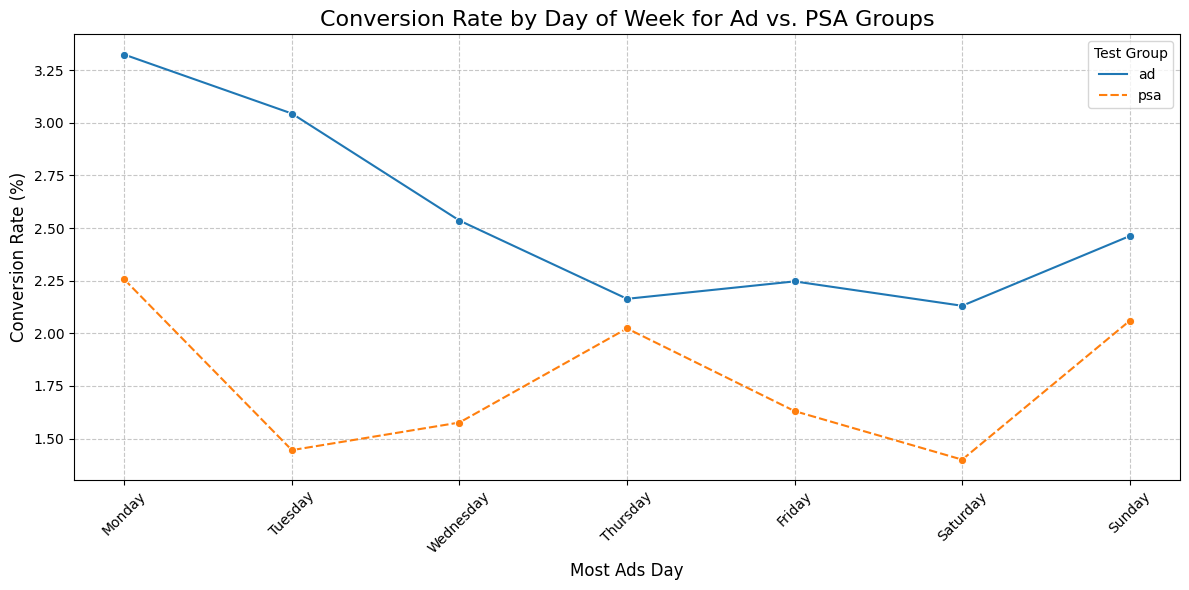

In [89]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=conversion_by_day.T, marker = 'o') # Transpose for plotting days on x-axis
plt.title('Conversion Rate by Day of Week for Ad vs. PSA Groups', fontsize=16)
plt.xlabel('Most Ads Day', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Test Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [86]:
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_interval'] = df['most ads hour'].apply(categorize_hour)

interval_order = ['Morning', 'Afternoon', 'Evening', 'Night']

conversion_by_interval = df.groupby(['test group', 'time_interval'])['converted'].mean().unstack() * 100
conversion_by_interval = conversion_by_interval[interval_order]
print(conversion_by_interval)

time_interval   Morning  Afternoon   Evening     Night
test group                                            
ad             2.116298   2.753141  2.824808  2.391759
psa            1.252174   2.014479  2.197802  1.441874


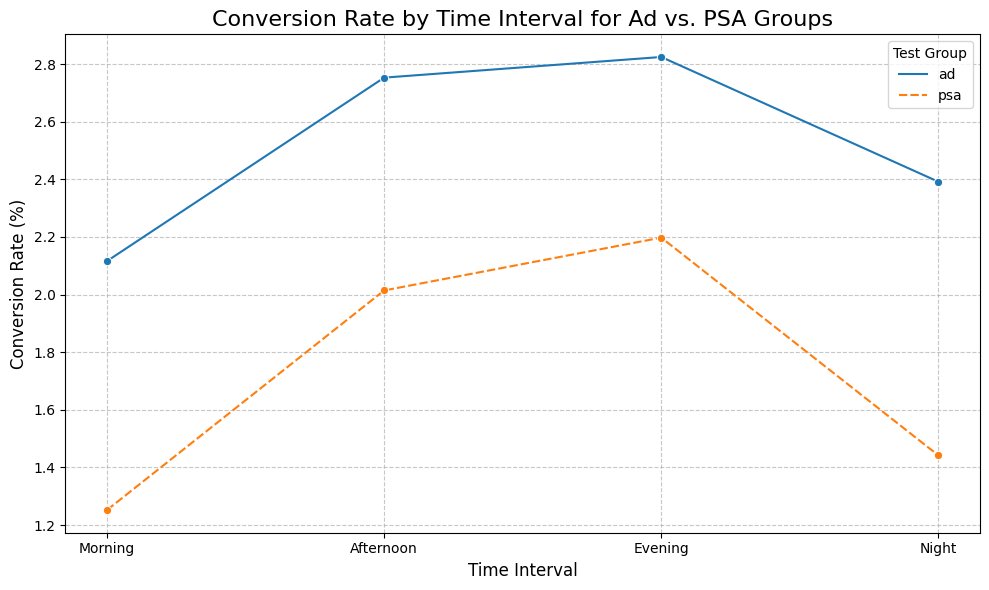

In [87]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=conversion_by_interval.T, marker='o')
plt.title('Conversion Rate by Time Interval for Ad vs. PSA Groups', fontsize=16)
plt.xlabel('Time Interval', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Test Group')
plt.tight_layout()
plt.show()

# Step 5: Conclusion

1. Compaign Success
   * the z-test showed a statistical significant difference in conversion rates as we rejected the null hypothesis (P_ad <= P_psa) in favor of the alternative hypothesis (P_ad > P_psa)
   * the obversed higher conversion rate for the ad gourp compared to the psa group is not due to random chance. the 'ad' compaign is indeed more effective in driving conversions than the public servoce announcement
2. Recommendations
   * the analysis on conversion rates by most ads day and most das hour provides insights on what time and what day the company should allocate more ad spend or impressions during those primal periods